# physic corpus feature extraction through tfidf
>Source
    https://www.kaggle.com/mrtroll/transfer-learning-on-stack-exchange-tags/physic-corpus-feature-extraction-through-tfidf-v1
    
Download nltk:
- wordnet
- averaged_perceptron_tagger
- punkt
- stopwords

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from subprocess import check_output
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
#nltk.download()

In [3]:
physic = pd.read_csv("../../input_light/physics_light.csv")

In [4]:
physic.head(5)

,id,title,content
0,1,spin relates subatomic particles,often hear subatomic particles property called...
1,2,simplest explanation string theory,would explain string theory non physicists spe...
2,3,lie theory representations particle physics,question posted many different forums thought ...
3,7,determinism ever possible,main problems need solve prove laplace determi...
4,9,hamilton principle,hamilton principle states dynamic system alway...


In [5]:
punctuations = string.punctuation

def data_clean(data):
    print('Cleaning data')
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    data = data.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    data = data.apply(lambda i: ''.join(i.strip(punctuations))  )
    #print('tokenize')
    data = data.apply(lambda x: word_tokenize(x))

    #Select only the nouns
    is_noun = lambda pos: pos[:2] == 'NN' 
    for i in range(len(data)):
        data[i] = [word for (word, pos) in nltk.pos_tag(data[i]) if is_noun(pos)]
    
    #print('Lemmatizing')
    wordnet_lemmatizer = WordNetLemmatizer()
    data = data.apply(lambda x: [wordnet_lemmatizer.lemmatize(i) for i in x])
    data = data.apply(lambda x: [i for i in x if len(i)>2])
    return(data)

In [6]:
def get_frequency(title):
    
    frequency = []
    inverse_frequency = {}
    for i in range(len(title)):
        word_count = {}

        for word in title[i]:
            if word in word_count:    
                word_count[word] = word_count[word] + 1
            else:
                word_count[word] = 1
                
        for word in word_count:
            if word in inverse_frequency:
                inverse_frequency[word] = inverse_frequency[word] + 1
            else:
                inverse_frequency[word] = 1            
        frequency.append(word_count)
        
    return (frequency, inverse_frequency)

In [8]:
title = data_clean(physic.title)
content = data_clean(physic.content)

Cleaning data
Cleaning data


In [10]:
print(title.head())
print(content.head())

0                         [spin, particle]
1                    [explanation, theory]
2    [lie, theory, representation, physic]
3                            [determinism]
4                    [hamilton, principle]
Name: title, dtype: object
0    [particle, property, spin, axis, particle, spi...
1                                          [physicist]
2    [question, forum, someone, answer, physicist, ...
3       [problem, determinism, uncertainty, principle]
4    [hamilton, principle, state, system, action, m...
Name: content, dtype: object


In [18]:
concat = []
for i in range(0, len(title)):
    concat.append(title[i] + content[i])

In [21]:
print(concat[1])

['explanation', 'theory', 'physicist']


In [53]:
frequency, inverse_frequency = get_frequency(content)

In [54]:
import operator
frequency_words = {}
for document in frequency:
    for word in document:
        if word in frequency_words:
            frequency_words[word] = frequency_words[word] + document[word]
        else:
            frequency_words[word] = document[word]            
frequency_words = sorted(frequency_words.values())

In [55]:
print('number of words:',len(frequency_words))

number of words: 40262


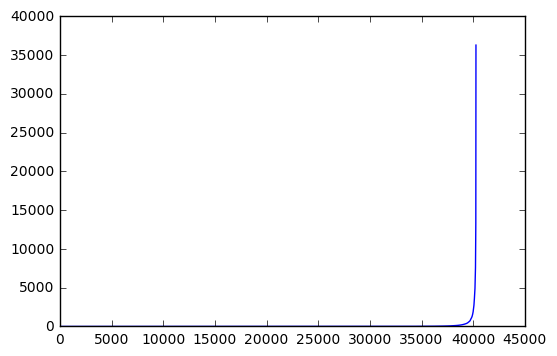

In [56]:
plt.plot(frequency_words)
plt.show()

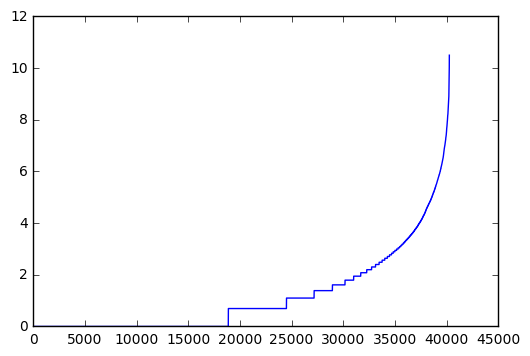

In [57]:
plt.plot(np.log(frequency_words))
plt.show()

In [58]:
tfidf = frequency

In [59]:
tfidf_distribution = []
for document in tfidf:
    if document == {}:
        continue
    max_frequency = sorted(document.items(), key=operator.itemgetter(1), reverse=True)[0][1]
    for word in document:
        document[word] = document[word]/(max_frequency + 0.0)*np.log(len(tfidf)/(inverse_frequency[word]+0.))
        tfidf_distribution.append(document[word])
    

In [60]:
index = 1

In [61]:
sorted(tfidf[index].items(), key=operator.itemgetter(1), reverse=True)

[('physicist', 4.2335451798561667)]

In [62]:
print(physic.title[index])
print(physic.content[index])

simplest explanation string theory
would explain string theory non physicists specially interested plausible needed successfully prove


In [63]:
tfidf_distribution = sorted(tfidf_distribution)
print(len(tfidf_distribution))

1587107


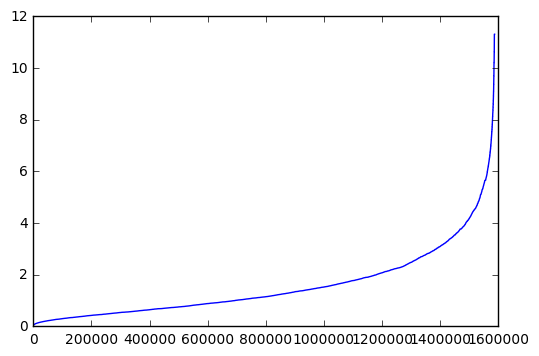

In [64]:
plt.plot(tfidf_distribution)
plt.show()

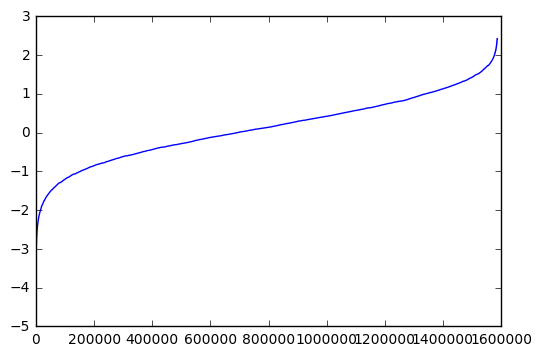

In [65]:
plt.plot(np.log(tfidf_distribution))
plt.show()

In [66]:
top = 8
output = []
for i in range(0,len(physic)):
    prediction = sorted(tfidf[i], key=tfidf[i].get, reverse=True)[0:top]
    output.append([physic.id[i], ' '.join(prediction)])

In [67]:
pd.DataFrame(data=output,columns = ['id','tags']).to_csv('SubmissionC.csv', index=False)       